# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# read in readmissions data provided
df_raw = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [3]:
# deal with missing and inconvenient portions of data 
df = df_raw[df_raw['Number of Discharges'] != 'Not Available']
df.loc[:, 'Number of Discharges'] = df['Number of Discharges'].astype(int)
df = df.sort_values('Number of Discharges')

C:\Users\t\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


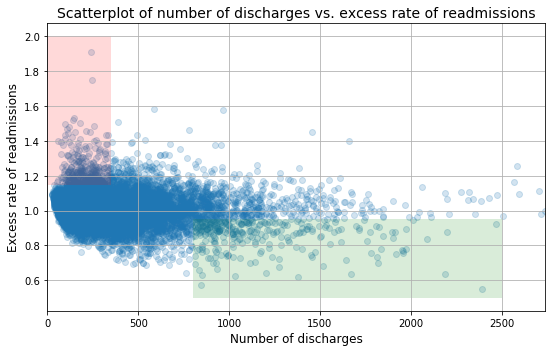

In [4]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
x = df['Number of Discharges'][81:-3]
y = df['Excess Readmission Ratio'][81:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
# Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

## A. Do you agree with the above analysis and recommendations? Why or why not?
There are a number of problems with the above analysis: Firstly, the effect size is quite small, and while that may reach significant in a large enough sample, there likely are more important sources of variation that policy recommendations should concentrate on. 

Secondly, no estimates of uncertainty are given (such as a confidence interval or a p-value). Thus, we don't even know if the effect is significant in the technical sense, and if so, at what significance level. 

Thirdly, no justification is given for the cut-off points that define large and small hospitals. Even worse, the cut-off points in the policy recommendations (and for the red and green shading in the plot) are different from those in the "hypothesis tests", which means that those recommendations are not directly backed up by evidence. 

Finally, since the variable of interest – excess readmission rate – is a ratio, we need to take its log in order to put upwards and downwards deviations from average onto the same scale. Failing to take the log makes large upwards deviation appear more pronounced than equally large downwards deviations: For example, if a hospital has three times as many readmissions as average, failing to take the log produces a score of three, while having only a third as many readmissions as average produces a score of 1/3. The former is 2 units away from baseline, the latter only .67. However, if we take the log, we get log(3) and log(1/3) = -log(3), which are equally away from baseline (0 in this case).

As a result, the above analysis exaggerates positive outliers and deemphasizes negative outliers. Looking at the above plot, the only thing that may suggest a relationship between hospital size and excess readmission rate are two particularly pronounced positive outliers, as well as a handful of less drastic outliers that get progressively less extreme as the number of discharges increases. By contrast, in my plot below, where I did take the log, those positive outliers are shrunken back towards the mean, and any visible relationship disappears.

## B. Provide support for your arguments and your own recommendations with a statistically sound analysis:
Before starting the actual analysis, let's change the unwieldy names of our two variables of interest to x (for the number of discharges) and y (for the excess readmission ratio). We will also drop observations that had zero discharges. 

The plot in the original analysis dropped three outliers that had a very high number of discharges, but it is unclear whether those were also dropped for the "hypothesis test."  I will only drop them for plotting, but I don't see any reason to drop them for my hypothesis tests.

In [5]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.interpolate import UnivariateSpline

In [6]:
# Rename columns
df = df.rename(columns={'Number of Discharges': 'x', 'Excess Readmission Ratio': 'y'})

# Delete observations with 0 cases
df = df.iloc[81:, :]
assert (df.x==0).sum()==0

df.loc[:,'log_y'] = np.log(df.y)

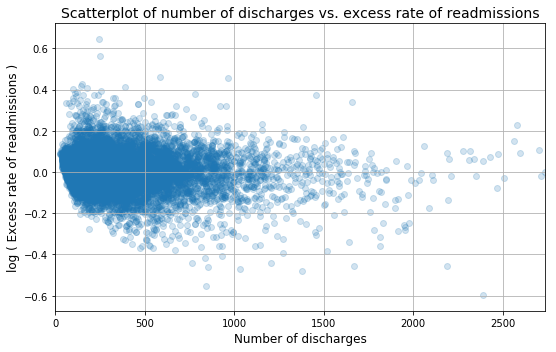

In [7]:
# Take the log of excess readmission rate and plot it
x = df.x[:-3]
log_y = df.log_y[:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, log_y, alpha=0.2, label='Hospital')

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('log ( Excess rate of readmissions )', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. '
             'excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

###  1. Setup an appropriate hypothesis test.

Firstly, let's see how the difference between small and large hospital changes if we take the log:

In [8]:
# Selecting small and large hospitals (log)
small_log = df.loc[df.x < 100, 'log_y']
large_log = df.loc[df.x > 1000, 'log_y']

print('Average log excess readmission rate for SMALL hospitals: {}\n'
      'Average log excess readmission rate for LARGE hospitals: {}\n'
      'Difference: {}'
        .format(np.exp(small_log.mean()), np.exp(large_log.mean()),
                np.exp(small_log.mean()) - np.exp(large_log.mean())))

Average log excess readmission rate for SMALL hospitals: 1.021075990409279
Average log excess readmission rate for LARGE hospitals: 0.9706114497336977
Difference: 0.05046454067558126


In [9]:
# Selecting for small and large hospitals (level)
small_level = df.loc[df.x < 100, 'y']
large_level = df.loc[df.x > 1000, 'y']

print('Average  excess readmission rate for SMALL hospitals: {}\n'
      'Average  excess readmission rate for LARGE hospitals: {}\n'
      'Difference: {}'
        .format(small_level.mean(), large_level.mean(),
                small_level.mean() - large_level.mean()))

Average  excess readmission rate for SMALL hospitals: 1.0226183501683506
Average  excess readmission rate for LARGE hospitals: 0.9783354211663071
Difference: 0.04428292900204345


It turns out that for the *mean* effect, it does not make much of a difference whether we take the log of the excess readmission ratio or not. This is because for values close to one, differences in the log are similar to differences in the level. Thus, it seems that – while outliers that were far enough from one skewed the visible relationship between hospital size and excess readmission ratio – if we only look at the mean for large and small hospitals, those outliers are swamped by the majority of data that are close enough to one. 

However, this points to another misleading feature of the plot in the above analysis: While it does try to deal with overplotting by making points semi-transparent, the chosen alpha of 0.2 is not nearly small enough to show where the majority of points lie. In my first version of the plot above, I kept this alpha constant for comparison with the original plot. But in my second version below, I will choose a much smaller alpha in order to not exaggerate the impact of a few points.

###  2. Compute and report the observed significance value (or p-value).

We will start by conducting a classical hypothesis test for independent samples, and then contact the same test using the bootstrap approach.

To conduct the t-test, let's first determine whether it is reasonable to assume that the variance is equal in both samples:

In [10]:
print('Variance for small hospitals: {}\n'
      'Variance for large hospitals: {}'
          .format(np.var(small_log, ddof=1), np.var(large_log, ddof=1)))

Variance for small hospitals: 0.0029388926621643705
Variance for large hospitals: 0.016433799433893406


The variance clearly seems larger in the sample with large hospitals. Therefore, we will need Welch's t-test, which is based on a separate estimate of variance for each sample. Since the analysis we are trying to critique suffers from a number of problems, we will adopt an agnostic position regarding the direction of any potential effect, and thus conduct a two-sided test. 

In [11]:
# Conduct Welch's t-test test (since we can't assume variances are equal)
stats.ttest_ind(small_log, large_log, equal_var=False)

Ttest_indResult(statistic=8.225822588213564, pvalue=1.5208461791228002e-15)

This shows a highly significant difference with a p-value of close to zero. 

Now let's repeat the same test using the bootstrap. In order to reuse a a function I wrote for a previous mini-project, I start by adding a categorical variable to the data frame that distinguishes small from large hospitals. 

In [12]:
# Make a variable for hospital size that is 1 for large and 0 for
# small and missing for medium size
df.loc[:, 'large'] = np.nan
df.loc[df.x < 100, 'large'] = 0
df.loc[df.x > 1000, 'large'] = 1

In [13]:
# Define function to permute data and compute test statistic
def permutation_stat(dataframe, v, group, statistic, rng):
    """
    Create a single permutation of the data, randomly assign groups, 
    and compute test statistic.
    
    Parameters
    ----------
    df : pd.DataFrame
        The data frame where the relevant variables are located.
    v : str
        Name of the variable in the data frame that contains the
        data for which to compute means.
    group : str
        Name of the variable in the data frame that contains a
        categorical variable that identifies the two groups for
        which to compute the test statistic.
    statistic : function
        Function that returns the test statistic of interest.
    rng : np.RandomState instance
        Random number generator.

    Returns
    -------
    numeric
        Value of the test statistic for the permutation sample.
    """

    # Permute values
    v_permuted = rng.permutation(dataframe.loc[:, v])
    
    # Randomly assign groups
    group_1 = v_permuted[: group_value_counts[0]]
    group_2 = v_permuted[group_value_counts[1]:]
    
    # Return test statistic
    stat = statistic(group_1, group_2)
    return(stat)


# Define function to calculate p-value
def p_value(replicates, observed_stat, two_sided=True):
    """
    Computes the p-value of a test statistic using bootstrap replicates.
    
    Parameters
    ----------
    replicates : pd.Series
        bootstrap replicates (i.e., the value of the test statistic for
        each bootstrap sample.
    observed_stat : numeric
        Value of the test statistic in the actual sample.
    two_sided : bool, optional
        Whether to conduct a one-sided or two-sided hypothesis test.
        Default: True (two-sided).
        
    Returns
    -------
    numeric
        p-value
    """
    
    # First compute what percentage of bootstrap replicates are LOWER
    p = (replicates < observed_stat).mean() 
    # If more than half are LOWER, compute what percentage is HIGHER 
    # (since we are interested in what proportion is more extreme).
    if p > 0.5:
        p = (replicates > observed_stat).mean()
    
    # If conducting a 2-sided test, adjust the p-value accordingly
    if two_sided == True:
        p = 2 * p
    return(p)


def btest_2samp(df, v, group, statistic, n_permutations=10000):
    """
    Performs a two-sided two-sample hypothesis test using the bootstrap.
    
    Parameters
    ----------
    df : pd.DataFrame
        The data frame where the relevant variables are located.
    v : str
        Name of the variable in the data frame that contains the
        data for which to compute means.
    group : str
        Name of the variable in the data frame that contains a
        categorical variable that identifies the two groups for
        which to compute the test statistic.
    n_permutations : numeric, optional
        Number of bootstrap replicates.  Default: 10000

    Returns
    -------
    numeric
        p-value 
    """

    # Count number of observations in each group
    global group_value_counts # For some reason doesn't work otherwise
    group_value_counts = df.loc[:, group].value_counts()
    
    # Compute actual test statistic
    data_1 = df.loc[df[group]==group_value_counts.index[0], v]
    data_2 = df.loc[df[group]==group_value_counts.index[1], v]
    actual_stat = statistic(data_1, data_2)
    
    # Create random number generator
    rng = np.random.RandomState(3)
    
    # Compute test statistic for each permutation replicate
    permutation_stats = np.empty(shape=n_permutations)
    for replicate in range(n_permutations):
        permutation_stats[replicate] = permutation_stat(df, v, group, 
                                                        statistic, rng)

    # Compute p-value
    return(p_value(permutation_stats, actual_stat))


# Define function to compute difference in means
def diff_in_means(s1, s2):
    """ Returns the difference in means between two pd.Series."""
    return (s1.mean() - s2.mean())


# Conduct 2-sample hypothesis test
print('p-value: ', btest_2samp(df=df.loc[df.large.notnull(), :], v='y', group='large', 
                    statistic=diff_in_means))

p-value:  0.0


### 3. Report statistical significance for $\alpha$ = .01. 

For both the bootstrap and the classical hypothesis test we get a p-value of basically 0.  This means that – if large and small hospitals indeed had the same number of readmissions – it is virtually impossible that we would observe as big or bigger of a difference in means between small and big hospitals as we did. 

Thus, for $\alpha$ = . 01, as well as for any other reasonable significance level, larger hospitals have indeed a significantly lower number of readmissions than smaller hospitals.

###  4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client? 

The comparison of means above showed that the effect size is fairly small: Large hospitals have about a 3% lower readmission rate, whereas small hospitals have about a 2% higher readmission rate. Thus, we should be careful not to over-interpret this strong significance: While our large sample size allows us to estimate the difference relatively precisely, and while we thus know that it is different from zero, we also know that it is very small.

Thus, the policy recommendations seem overblown. While there clearly is a lot of money wasted through inefficient and low-quality healthcare, the priority should be to find more important sources of variations. Hospitals clearly vary a lot in terms of their outcomes, so a more complex model that includes a wide range of predictors is necessary in order to achieve better separation between low and high quality hospitals.

Furthermore, policy cannot simply focus on improving quality per se, the key is rather quality *given* cost.  

###  5. Look at the scatterplot above

**– What are the advantages and disadvantages of using this plot to convey information?**

**– Construct another plot that conveys the same information in a more direct manner. **

An advantage of the original plot is that, since it shows all the data, it give the picture of the whole distribution, rather than just focusing on the average, which can sometimes be misleading. On the other hand, it does not show the whole distribution as good as it could, because – as mentioned above – it does not sufficiently correct for overplotting. More importantly, while it does do a reasonable job showing variation around the mean, it does not explicitly show the mean itself. This could be done, for example, by plotting the mean effect for small and large hospitals over the points. This would also instantly point out the meager effect size, which in turn would call the study's grand policy recommendations into question . Finally, as already mentioned, the failure to take the log of the excess readmission ratio further contributes to creating the  illusion of a stronger effect. 


There are two different strategies for improvement: Firstly, we could use a bar chart to only plot the mean excess readmission ratio for each group. This is the central information we want to convey, so it is better to not add too many distractions.  One important point to remember is to let the x-axis start at zero, in order to show that the effect size is small. To visualize the uncertainty of our estimate, we should include error bars to show the standard errors for each group (though those are different from the standard deviation of the difference, and less statistically skilled readers might be inclined to believe that the effect is significant as long as the error bars from both groups do not overlap) . 

The second strategy is to make a plot similar to the original one, but to remedy its shortcomings.  Thus, the plot would be on the log-scale, and the transparency of the points would be increased in order to ameliorate overplotting. Most importantly, we would visualize the mean. I decided to do the latter not through a horizontal line each for small and large hospitals, but rather by fitting a smoothing spline. This is more appropriate, because it does not depend on arbitrary cutoff points for hospital size. Like a polynomial, it is able to detect non-linear relationships, but it has the advantage that it is better-behaved at the edges of the distribution. This is particularly important because there are a number of outliers with a large number of cases. (If we wanted to go even further, we could add a confidence interval using the bootstrap approach.) Note that, while the log-scale is harder for us to interpret intuitively, the effect size is small enough that it will equal the effect on the original scale.

In [14]:
# Fit smoothnig spline
# Group log_y by x and take average to make x strictly increasing
avg_log_y = df.loc[:,['x', 'log_y']] \
            .groupby('x') \
                .mean()

# Estimate spline
s = UnivariateSpline(x=avg_log_y.index, y=avg_log_y.log_y)

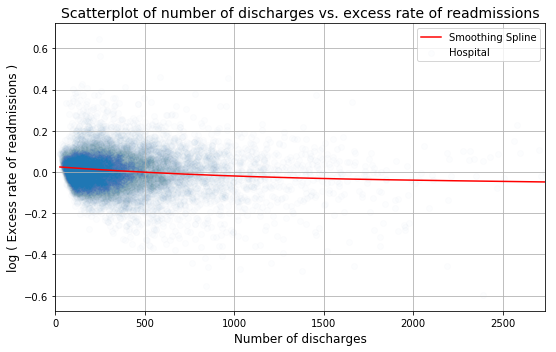

In [15]:
# Take the log of excess readmission rate plot it
x = df.x[:-3]
log_y = df.log_y[:-3]

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, log_y, alpha=0.01, label='Hospital')
ax.plot(avg_log_y.index, s(avg_log_y.index), 
        label='Smoothing Spline', color='red')

ax.legend()
ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('log ( Excess rate of readmissions )', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. '
             'excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()